# 15-9. 프로젝트 : 다양한 OCR모델 비교하기


- import

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


## 기획

#### 해외 안내판 번역기 만들기

- 해외 여행 시 지하철을 타거나 안내판의 주의 문구를 살펴볼 때에 유용하게 쓸 수 있는 번역기 만들기.
- 그러기 위해서는 촬영되거나 저장된 이미지 속의 문자를 인식해야 함(OCR)

#### OCR 모델의 평가 기준

1. 작은 글씨라도 정확히 인식해야 한다.
2. 시간 지체 없이 결과를 출력해야 한다.

## Step1. 검증용 데이터셋 준비


In [9]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://images.unsplash.com/photo-1586187019847-c6e78f015acc?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1yZWxhdGVkfDE5fHx8ZW58MHx8fHw%3D&auto=format&fit=crop&w=500&q=60',
  'https://images.unsplash.com/photo-1511820377299-7f87b34ce70f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=464&q=80',
  'https://images.unsplash.com/photo-1508002792052-75093a14fe6f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=465&q=80',
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

## Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항: 진행 하지 않음)


### (1) Keras-ocr

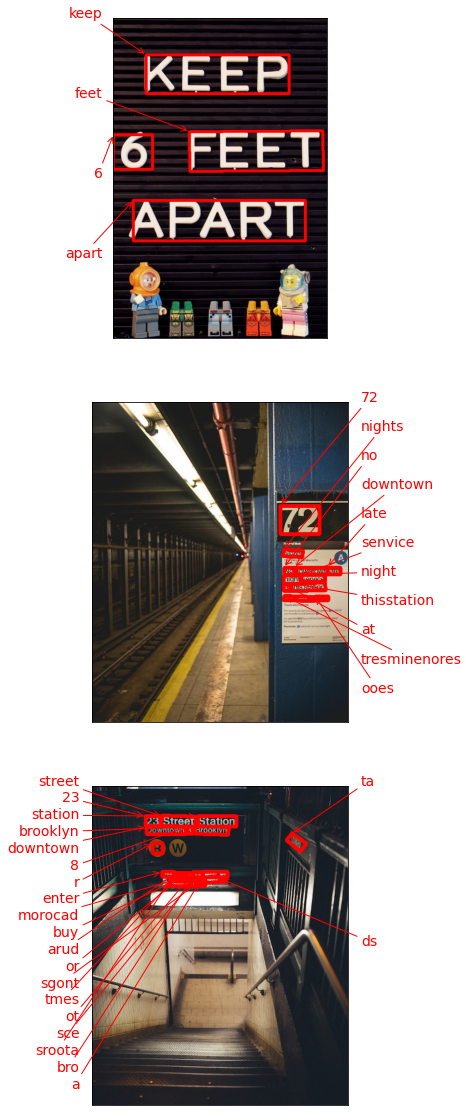

In [10]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx]
                        , predictions=prediction_groups[idx][0]
                        , ax=ax)

In [11]:
for idx, ax in enumerate(axs):
    print(idx, ax)

0 AxesSubplot(0.43848,0.657941;0.148039x0.222059)
1 AxesSubplot(0.423676,0.391471;0.177647x0.222059)
2 AxesSubplot(0.423638,0.125;0.177723x0.222059)


In [12]:
import pandas as pd
df = pd.DataFrame(prediction_groups[idx][0], columns=["word", "xy"])

### (2) 테서랙트

In [14]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")


In [16]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path_01 = work_dir + '/image01.png'   

cropped_image_path_list_01 = crop_word_regions(img_file_path_01, work_dir+'/output01')
recognize_images(cropped_image_path_list_01)

/aiffel/aiffel/ocr_python/output01/0000.png

Done


In [18]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path_02 = work_dir + '/image02.png'   

cropped_image_path_list_02 = crop_word_regions(img_file_path_02, work_dir+'/output02')
recognize_images(cropped_image_path_list_02)

/aiffel/aiffel/ocr_python/output02/0000.png

Done


테서랙트는 이미지를 전혀 인식하지 못함.

## Step4. 결과 분석과 결론 제시


우선 두 모델 모두 비교적 간단한 문장의 지시판이었음에도 불구하고 정확한 문자인식이 불가능했습니다.
심지어 테서랙트는 같은 이미지를 사용했는데도 불구하고 문자를 전혀 인식하지 못했습니다.
빠르고 정확한 문자인식을 위해서는 더 나은 모델이 필요해 보입니다.

구글lens 실시간 이미지 분석 모델이 제공되고 있었습니다.

<구글lens : 3번 이미지 예시>
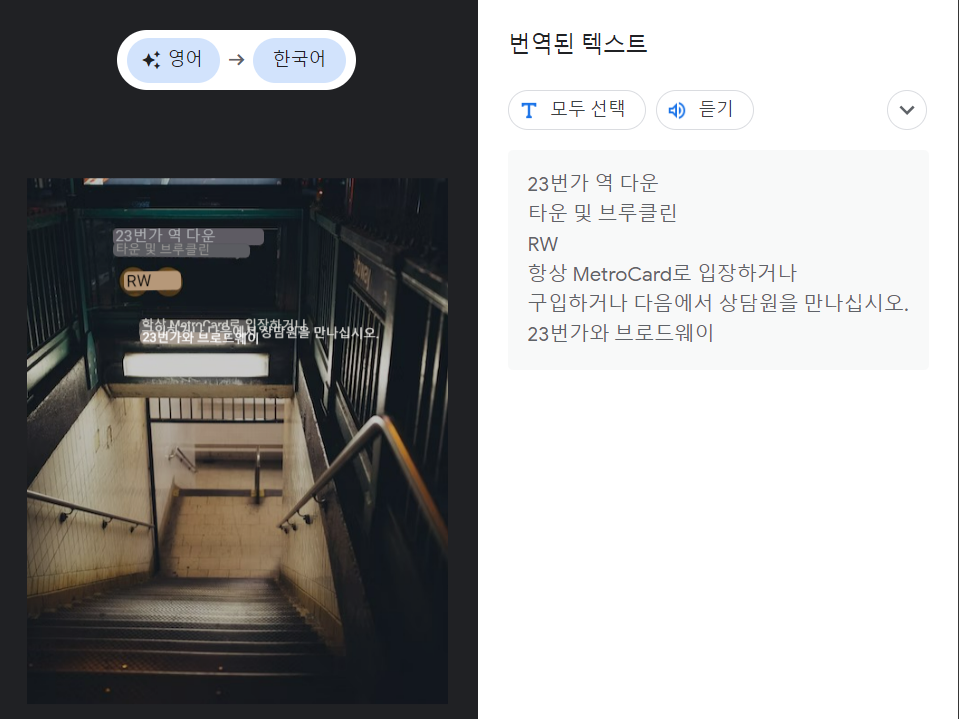

감사합니다~